In [1]:
# Nelder-Mead simplex search
%matplotlib inline
%run Trajectory_Simulation.ipynb

# i'm sorry for global vars...
global allvectors, allobjval
allvectors = []               # array for all design vecs, global variable
allobjfun = []                # array for tracking objective function evaluations
TARGET = True # true if we are aiming for nominal impact point, false if we are maximizing distance from launch site
SIMPLEX = True # true if we're using simplex method, false if we're using genetic algorithm

/home/cory/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The purpose of this notebook is to determine the optimal launch azimuth and elevation angles, in order to maximize the likelihood of landing in a particular region. Eventually, this should be expanded to enable input of day-of wind measurements so that we can determine these settings on the day of the launch. We may need to optimize the trajectory simulation code for this purpose, perhaps with less degrees of freedom, since it is currently fairly slow.

This program has essentially the same structure as the MDO and differs only in how trajectory performance is evaluated and which parameters are held constant or optimized over. Examination of the differences should enable one to make similar programs for different but related purposes.

## Functions of Merit
We chose to abstract all of the functions used within the merit function for increased flexibility, ease of reading, and later utility. We use convex functions four our optimization, but we don't use much of the theory of convex optimization.

* **objective_additive** is arbitrarily constructed. It is
    * appropriate for vector-valued measurements,
    * not normalized,
    * squared to reward (or punish) relative to the distance from nominal value, and
    * divided by two for aesthetic reasons.
* **objective** is arbitrarily constructed. It is
    * normalized (by a somewhat arbitrary constant) to bring it into the same range as constraints,
    * squared to reward (or punish) relative to the distance from nominal value, and
    * divided by two so that our nominal value is 0.5 instead of 1.0.
* **exact** is less arbitrarily constructed. It is
    * squared to be horizontally symmetric (which could also be obtained by absolute value),
    * determined by the distance from a constant, and
    * divided by two is for aesthetic value.
* **exterior** is not particularly arbitrary. It is
    * boolean so that we can specify whether it is minimizing or maximizing its variable,
    * 0 when the inequality is satisfied, otherwise it is just as punishing as **exact**.
* **barrier** comes in two flavors, one of which is not used here. It is
    * boolean so that we can specify whether it is a lower or an upper bound,
    * completely inviolable, unlike exact and exterior penalties.
    
Technically logarithmic barrier functions allow negative penalties (i.e. rewards), but since we use upper and lower altitude barriers, it is impossible that their sum be less than 0. If the optimizer steps outside of the apogee window, the barrier functions can attempt undefined operations (specifically, taking the logarithm of a negative number), so some error handling is required to return an infinite value in those cases. Provided that the initial design is within the feasible region, the optimizer will not become disoriented by infinite values.

In [2]:
# all of our comparisons are ratios instead of subtractions because
# it's normalized, instead of dependent on magnitudes of variables and constraints

def objective_additive(var, cons):
    return np.linalg.norm(var - cons)**2 / 2

# minimize this, **2 makes it well behaved w.r.t. when var=cons
def objective(var, cons):
    return (var/cons)**2 / 2

# **2 because i like it more than abs(), but that also works
def exact(var, cons):
    return (var/cons - 1)**2 / 2

# this is your basic exterior penalty, either punishes for unfeasibility or is inactive
def exterior(var, cons, good_if_less_than=False):
    if good_if_less_than:
        return max(0, var/cons - 1)**2 / 2
    else:
        return max(0, -(var/cons - 1))**2 / 2

# this barrier function restricts our objective function to the strictly feasible region
# make rockets great again, build that wall, etc, watch out for undefined operations
def barrier(var, cons, int_point=False, good_if_less_than=True):
    global dbz
    try: # just in case we accidentally leave feasible region
        if not int_point:
            if good_if_less_than:
                return -log(-(var/cons - 1))
            else:
                return -log(var/cons - 1)
        elif int_point:
            def interior(g): return 1/g # in case we don't like logarithms, which is a mistake
            if good_if_less_than:
                return -interior(var/cons - 1)
            else:
                return -interior(-(var/cons - 1))
    except:
        return float('inf') # ordinarily, this is bad practice since it could confuse the optimizer
                            # however, since this is a barrier function not an ordinary penalty, i think it's fine

## Optimization Problem
Given a design vector $x$ and the iteration number $n$ our merit function **cost** runs a trajectory simulation and evaluates the quality of that rocket. We keep track of each design and its merit value for later visualization, hence why global variables are used.

We run an iterative sequence of optimization routines with a decreasing barrier function and increasing penalty functions so that the optimization can range over a larger portion of the design space away from its boundaries before settling into local minima closer to the boundary.

In [3]:
# this manages all our constraints
# penalty parameters: mu -> 0 and rho -> infinity 
def penalty(alt, mu, rho):
    b = [barrier(alt, CONS_ALT, int_point=False, good_if_less_than=False)
        ]
    eq = []
    ext = [
          ]
    return mu*sum(b) + rho*(sum(eq) + sum(ext))

# Pseudo-objective merit function
# x is array of design parameters, n is index of penalty and barrier functions
def cost(x, nominal):
    global allvectors, allobjfun
    # get trajectory data
    sim = trajectory(163.36, 3.091, 71548.393, THROTTLE_WINDOW, MIN_THROTTLE, RCS_MDOT, RCS_P_E, RCS_P_CH, 
                        0, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, AIRFRM_IN_RAD,
                          OF, ENG_P_CH, ENG_T_CH, ENG_KE, ENG_MM,
                          [0, 0, x[0], x[1], False, 0, 0, 0, 0, 0, 0, False], 
                          0.05, True, 0.04, True, True)
    
    # either minimize the distance from nominal impact point
    if TARGET:
        #nominal = np.array([nominal, kludge])
        obj_func = objective_additive(sim.impact, nominal)
    # or maximize distance from launch point
    else:
        obj_func = - objective_additive(sim.impact, sim.env.launch_pt)
    
    pen_func = penalty(sim.LV4.apogee, MU_0 / (2**1), RHO_0 * (2**1))
    # add objective and penalty functions
    merit_func = obj_func + pen_func
    allvectors.append(x) # maintains a list of every design, side effect
    allobjfun.append(merit_func)
    #print("vec:", x,'\t', "impact:", sim.impact, '\t', "alt:", sim.LV4.apogee)
    return merit_func

# we want to iterate our optimizer for theoretical "convergence" reasons (given some assumptions)
# n = number of sequential iterations
def iterate(func, x_0, n, nominal):
    x = x_0
    designs = []
    for i in range(n):
        print("Iteration " + str(i+1) + ":")
        # this minimizer uses simplex method
        res = minimize(func, x, args=(nominal), method='nelder-mead', options={'disp': True, 'xatol': 0.01, 'fatol': 0.01})
        x = res.x # feed optimal design vec into next iteration
        
        designs.append(res.x)   # we want to compare sequential objectives
    return x

# this is for experimenting with stochastic optimization, which takes much longer but may yield more global results.
def breed_rockets(func, nominal):
    res = differential_evolution(func=func, bounds=[(0, 360), (-25, 1)], args=((nominal)),
                                 strategy='best1bin', popsize=80, mutation=(.1, .8), recombination=.05,
                                 updating='immediate', disp=True, atol=0.05, tol=0.05,
                                 polish=True,workers=-1)
    return res.x

# Top-Level of Optimization Routine
Here's where the magic happens. This code block runs the iterative optimization and provides details from our optimized trajectory.

In [4]:
# this either maximizes distance from launch site or minimizes distance from nominal impact point
if __name__ == '__main__':
    if TARGET:
        target_pt = np.array([32.918255, -106.349477])
    else:
        target_pt = None
        
    if SIMPLEX:
        x0 = np.array([0, 0])
        # feed initial design into iterative optimizer, get most (locally) feasible design
        x = iterate(cost, x0, 1, nominal = target_pt)
            
    else:
        # probe design space, darwin style. if design space has more than 3 dimensions, you might need this. takes forever.
        x = breed_rockets(cost, nominal = target_pt)
            
    print("Optimization done!")

Iteration 1:
vec: [125.  -2.] 	 impact: [  32.349 -105.935] 	 alt: 115322.29515493102
vec: [131.25  -2.  ] 	 impact: [  32.253 -106.029] 	 alt: 115307.07476238906
vec: [125.   -2.1] 	 impact: [  32.331 -105.905] 	 alt: 114559.9659650037
vec: [118.75  -2.1 ] 	 impact: [  32.438 -105.822] 	 alt: 114557.49799027946
vec: [118.75  -2.  ] 	 impact: [  32.454 -105.854] 	 alt: 115320.0020601768
vec: [115.625  -1.95 ] 	 impact: [  32.516 -105.835] 	 alt: 115685.58021024149
vec: [121.875  -1.85 ] 	 impact: [  32.427 -105.94 ] 	 alt: 116426.31825351808
vec: [123.438  -1.725] 	 impact: [  32.426 -106.001] 	 alt: 117307.1607375117
vec: [114.062  -1.675] 	 impact: [  32.583 -105.916] 	 alt: 117634.66158910096
vec: [108.594  -1.512] 	 impact: [  32.693 -105.933] 	 alt: 118684.03592138458
vec: [116.406  -1.287] 	 impact: [  32.607 -106.08 ] 	 alt: 120095.8562592715
vec: [116.797  -0.956] 	 impact: [  32.659 -106.211] 	 alt: 121899.84360056184
vec: [101.953  -0.744] 	 impact: [  32.868 -106.22 ] 	 alt:

Azimuth Perturbation: 99.67777606994935
Elevation Perturbation: -0.44198545708981557
Launch point [  32.99  -106.969]
Impact point [  32.918 -106.348]



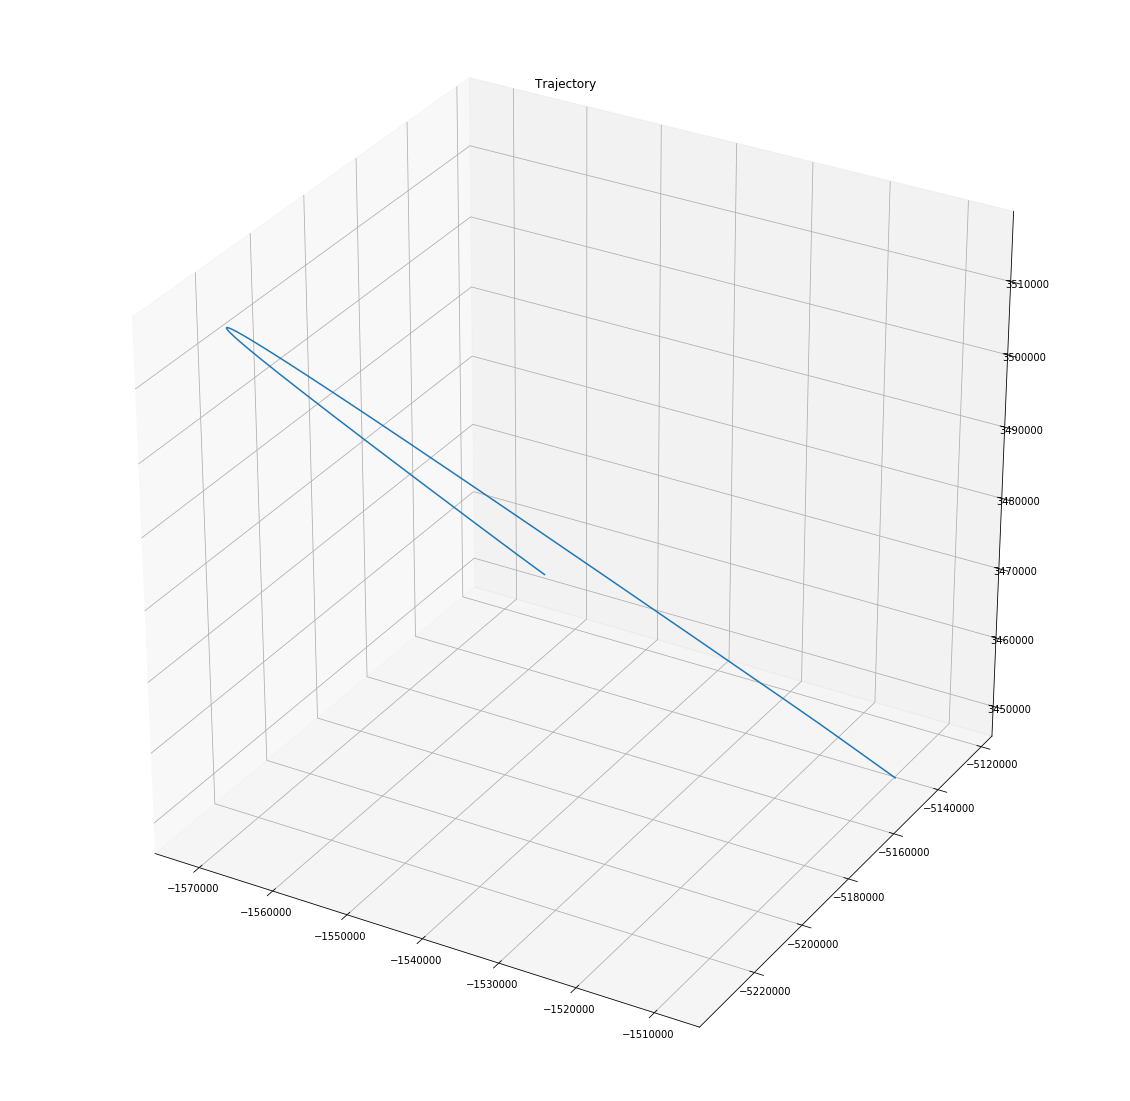

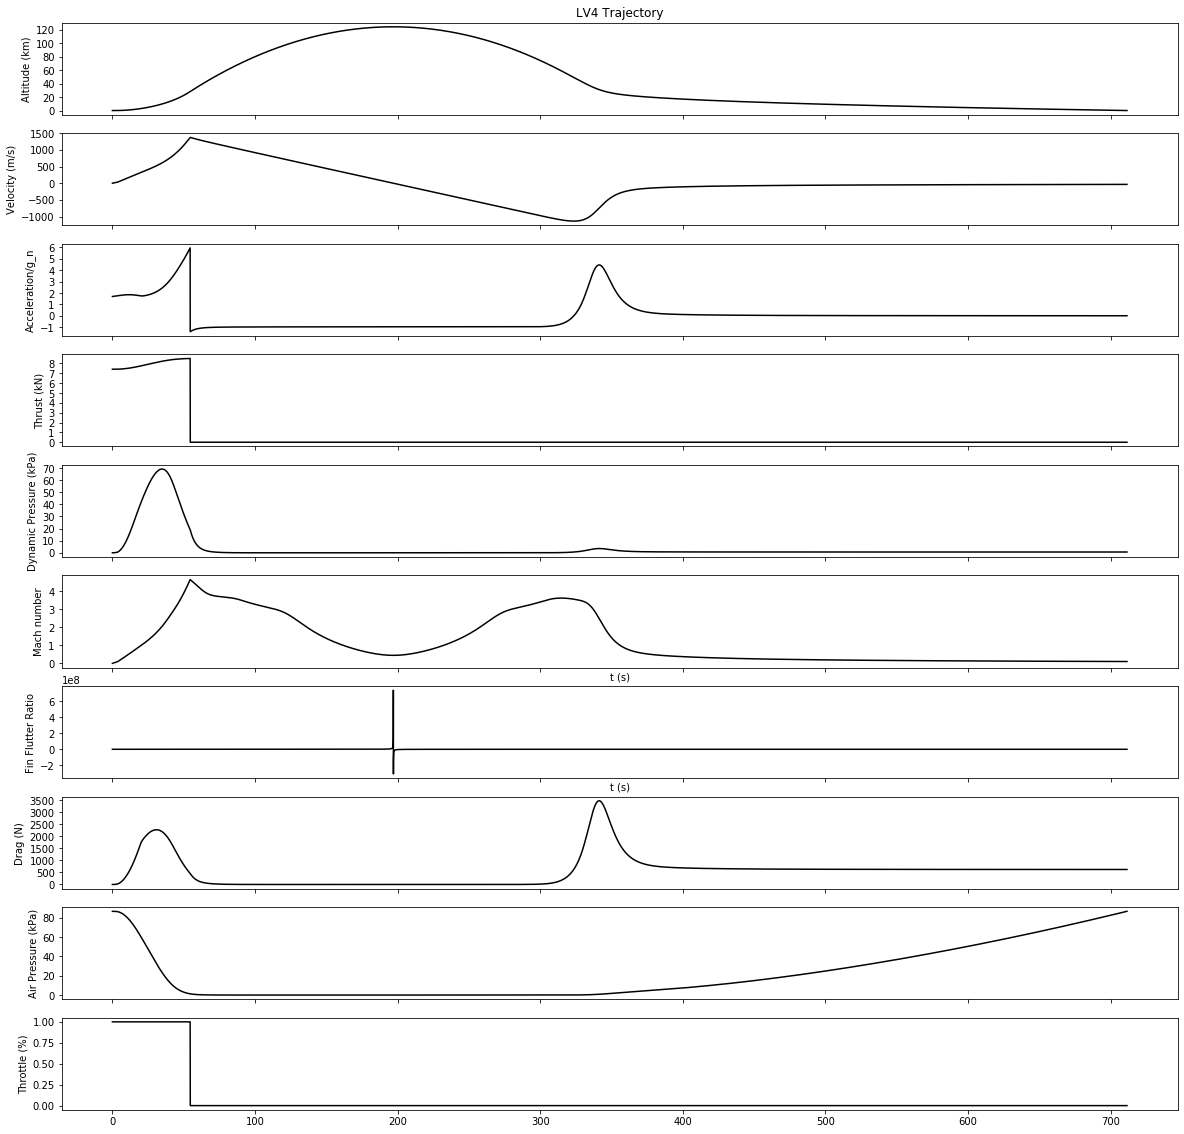


DESIGN VECTOR

-----------------------------

design total propellant mass               = 163.283 kg

design mass flow rate                      = 3.091 kg/s

design nozzle exit pressure                = 71548.393 Pa

total tankage length (after adjustment)    = 2.952 m

design airframe diameter                   = 0.305 m.

design airframe total length               = 7.649 m.

design GLOW                                = 279.980 kg

design ballast mass                        = 0.000 kg

design fin root chord                      = 0.700 m

design fin tip chord                       = 0.450 m

design fin sweep angle                     = 70.000 deg

design fin span                            = 0.420 m

design fin thickness                       = 3.175 mm



CONSTRAINTS

-----------------------------

Largest angle of attack (c.f. < 10.0)         = 0.228 deg

L/D ratio (c.f. < 22.0)                       = 25.096

fin flutter ratio (c.f. > 1.0)                       = 26.711

Sommer

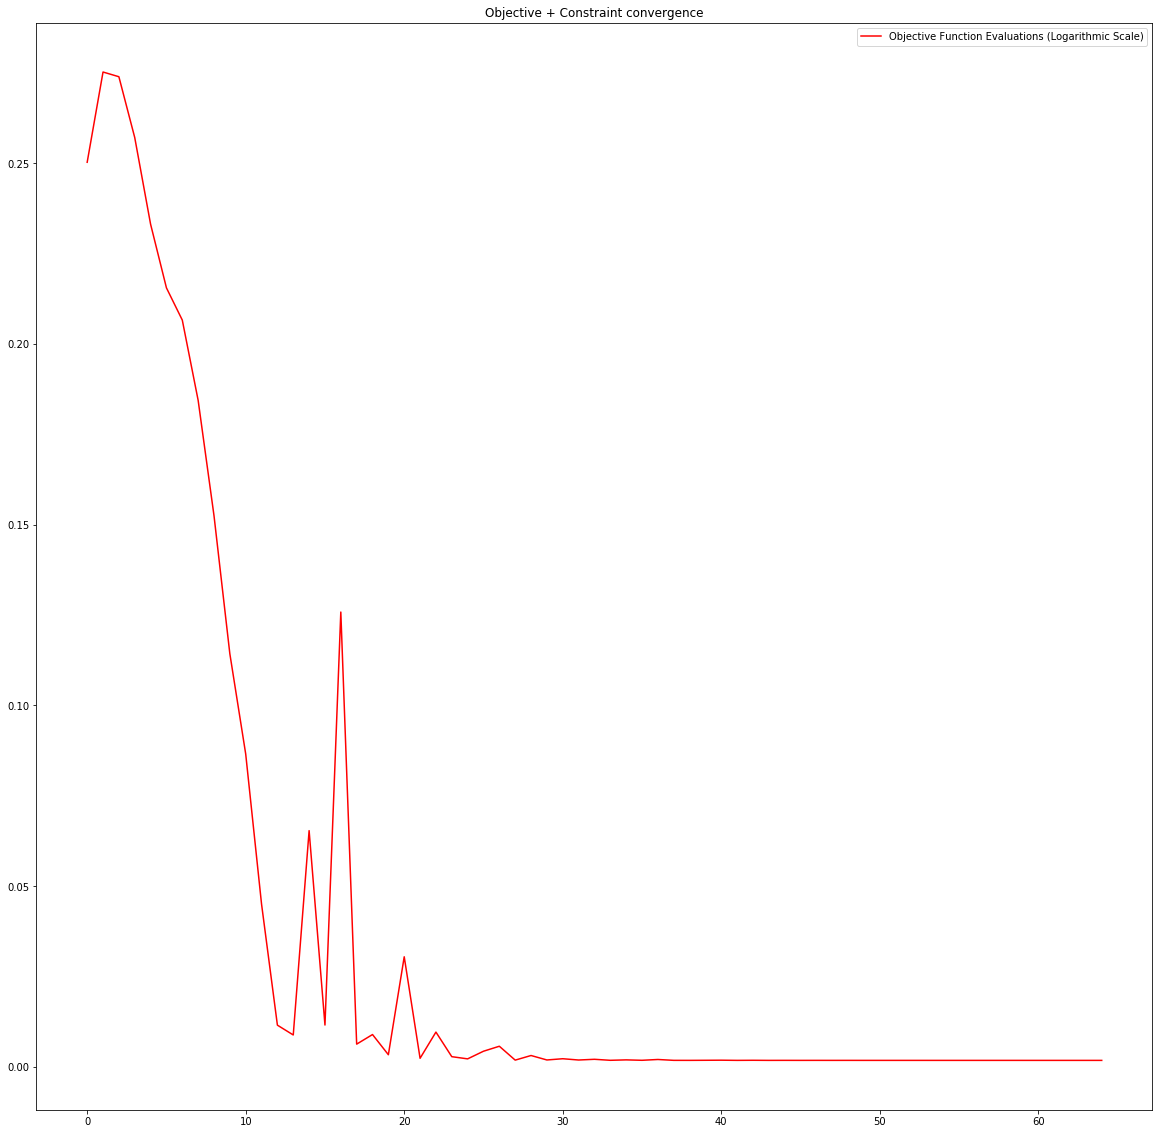

No handles with labels found to put in legend.


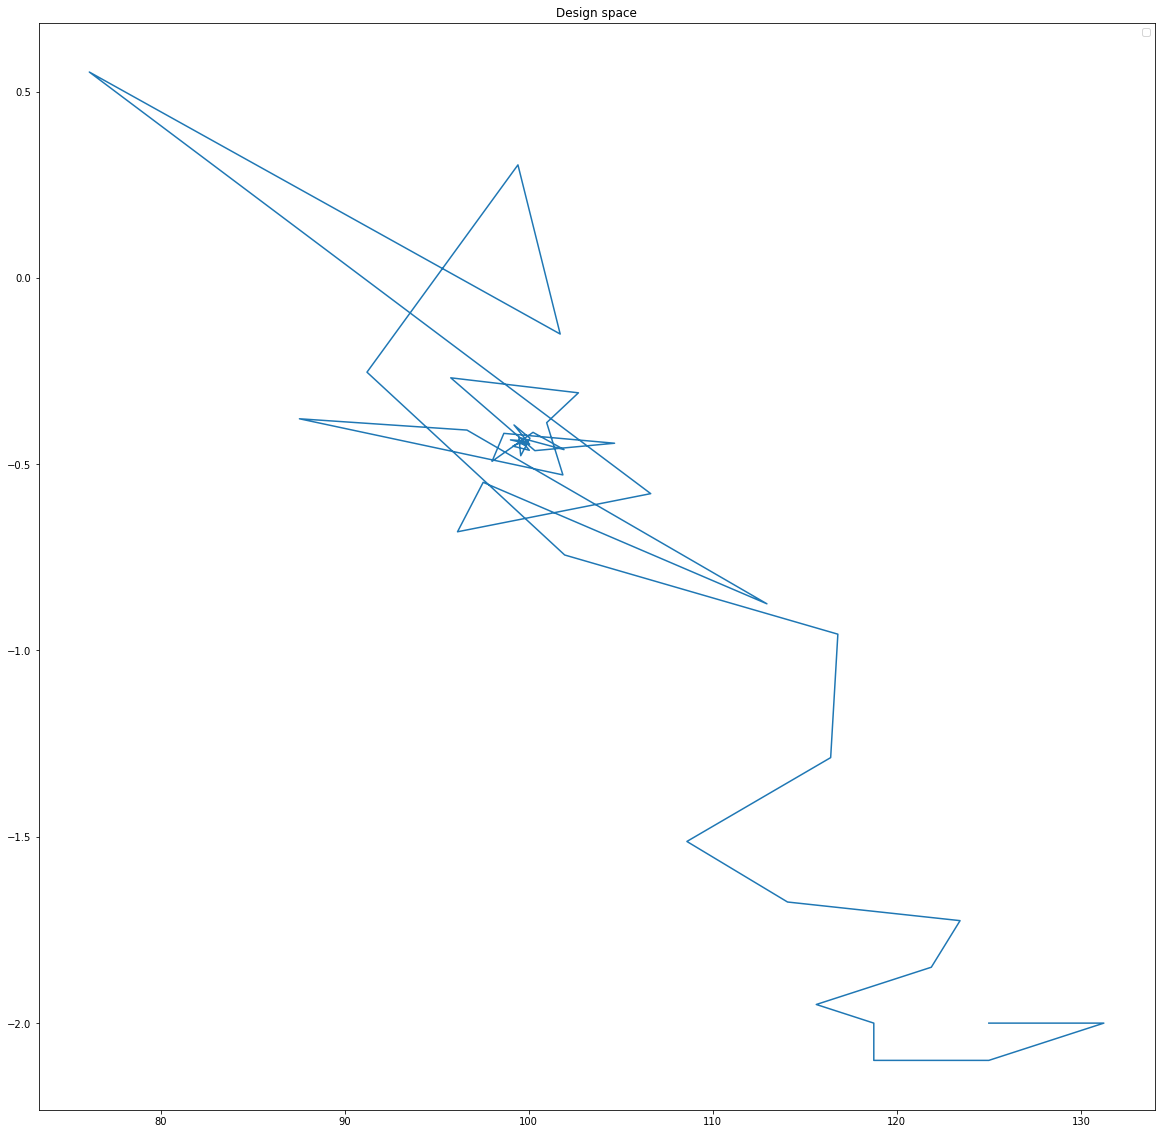

In [5]:
if __name__ == '__main__':
# Rename the optimized output for convenience
    az_perturb    = x[0]
    el_perturb    = x[1]
    
    
    # get trajectory info from optimal design
    sim = trajectory(163.36, 3.091, 71548.393, THROTTLE_WINDOW, MIN_THROTTLE, RCS_MDOT, RCS_P_E, RCS_P_CH, 
                        0, FIN_ROOT, FIN_TIP, FIN_SWEEP_ANGLE, FIN_SEMISPAN, FIN_THICKNESS, AIRFRM_IN_RAD,
                          OF, ENG_P_CH, ENG_T_CH, ENG_KE, ENG_MM,
                          [0, 0, az_perturb, el_perturb, False, 0, 0, 0, 0, 0, 0, False], 
                          0.05, False, 0.04, True, False)
    
    print("Azimuth Perturbation:", az_perturb)
    print("Elevation Perturbation:", el_perturb)
    print("Launch point", sim.env.launch_pt)
    print("Impact point", sim.impact)
    print()
    
    textlist = print_results(sim, False)
    # draw pretty pictures of optimized trajectory
    rocket_plot(sim.t, sim.alt, sim.v, sim.a, sim.thrust,
                sim.dyn_press, sim.Ma, sim.m, sim.p_a, sim.drag, sim.throttle, sim.fin_flutter, sim, False, None, None)
    
    # get/print info about our trajectory and rocket
    for line in textlist:
        print(line)
    
    # draw more pretty pictures, but of the optimizer guts
    design_grapher(allvectors)